# Exploratory Data Analysis of Pneumothorax dataset

## Preparations

### Imports

In [294]:
# Data handling imports
import pandas as pd
pd.reset_option('max_colwidth')
import numpy as np

# Read DICOM format
import pydicom

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

# General purpose imports
import os
from glob import glob

# Benchmark \ Baseline U-net
# pip install segmentation-models-pytorch
import segmentation_models_pytorch as smp

### Set Paths

In [257]:
# general folder path
user = 'roy' # 'or' \ 'roy'
if user == 'roy':
    folder_path = '/Users/royrubin/Downloads/siim/' 
else:
    folder_path = '... OR - your path'
    
# paths for files
train_rle_encodings_file_path = os.path.join(folder_path, 'train-rle.csv')
train_files_path = os.path.join(folder_path, 'dicom-images-train/')
test_files_path = os.path.join(folder_path, 'dicom-images-test/')

print(f'train_rle_encodings_file_path: {train_rle_encodings_file_path}')
print(f'train_files_path: {train_files_path}')
print(f'test_files_path: {test_files_path}')

train_rle_encodings_file_path: /Users/royrubin/Downloads/siim/train-rle.csv
train_files_path: /Users/royrubin/Downloads/siim/dicom-images-train/
test_files_path: /Users/royrubin/Downloads/siim/dicom-images-test/


### Handle uncomfotable and uneeded subdirs

In [258]:
#reading all dcm files into train and text
if user == 'roy':
    # then i downloaded the data from: 'https://www.kaggle.com/datasets/seesee/siim-train-test'
    train_file_names = sorted(glob(train_files_path + "*/*/*.dcm"))
    test_file_names = sorted(glob(test_files_path + "*/*/*.dcm")) # sorted([f for f in listdir(test_files_path) if '.dcm' in f])
    
print(f"\ntrain files: amount {len(train_file_names)}, examples: \n{train_file_names[0]}\n{train_file_names[1]}")
print(f"\ntest files: amount {len(test_file_names)}, examples: \n{test_file_names[0]}\n{test_file_names[1]}")


train files: amount 12089, examples: 
/Users/royrubin/Downloads/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.1000.1517875165.878026/1.2.276.0.7230010.3.1.3.8323329.1000.1517875165.878025/1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027.dcm
/Users/royrubin/Downloads/siim/dicom-images-train/1.2.276.0.7230010.3.1.2.8323329.10000.1517875220.938529/1.2.276.0.7230010.3.1.3.8323329.10000.1517875220.938528/1.2.276.0.7230010.3.1.4.8323329.10000.1517875220.938530.dcm

test files: amount 3205, examples: 
/Users/royrubin/Downloads/siim/dicom-images-test/_/_/ID_0011fe81e.dcm
/Users/royrubin/Downloads/siim/dicom-images-test/_/_/ID_003206608.dcm


### Read the RLE encondings csv

In [273]:
%%time
# read train-rle.csv
train_rle_encodings_df = pd.read_csv(train_rle_encodings_file_path, delimiter=",")
train_rle_encodings_df.rename(columns={" EncodedPixels": "EncodedPixels"}, inplace=True)

CPU times: user 70.8 ms, sys: 40.8 ms, total: 112 ms
Wall time: 177 ms


In [247]:
print(f'size {train_rle_encodings_df.shape}')
train_rle_encodings_df.head(3)

size (12954, 2)


,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6904.151787520...,-1
1,1.2.276.0.7230010.3.1.4.8323329.13666.15178752...,557374 2 1015 8 1009 14 1002 20 997 26 990 32 ...
2,1.2.276.0.7230010.3.1.4.8323329.11028.15178752...,-1


### Read images train data from DICOM format

In [244]:
%%time
# around 2 mins
temp = [{'UID': pydicom.read_file(file_name).SOPInstanceUID, 'Image': pydicom.read_file(file_name).pixel_array} 
                for file_name in train_file_names]
train_images_df = pd.DataFrame(temp)

CPU times: user 1min 52s, sys: 17 s, total: 2min 9s
Wall time: 2min 31s


In [245]:
print(f'size {len(train_images_df)}')
print(f'shape of single image {train_images_df.iloc[0].Image.shape}')
train_images_df.head(3)

size 12089
shape of single image (2,)


,UID,Image
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,"[[78, 81, 81, 81, 82, 82, 84, 90, 92, 95, 87, ..."
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,"[[4, 8, 7, 6, 7, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5,..."


### Read metadata train data from DICOM format

In [167]:
%%time
# around 30 secs
train_metadata = [pydicom.dcmread(file_name) for file_name in train_file_names]

CPU times: user 19 s, sys: 8.53 s, total: 27.5 s
Wall time: 42.9 s


In [ ]:
print(type(train_metadata[0]))

<class 'pydicom.dataset.FileDataset'>


### Function for viewing single patient data extracted from pydicom format

In [169]:
def show_patient_data(patient_file_name: str):
    #displaying metadata
    data = pydicom.dcmread(patient_file_name)
    print(data)
    
    #displaying the image
    img = pydicom.read_file(patient_file_name).pixel_array
    plt.figure(0)
    plt.grid(False)
    plt.imshow(img, cmap='bone')

### Function for generating metadata pandas dataframe

In [170]:
def generate_metadata_dataframe(train_metadata: list, masks: pd.DataFrame):
    
    patients = pd.DataFrame()

    for data in train_metadata:
        patient = dict()
        
        # save the wanted features from the dicom foramt
        patient["UID"] = data.SOPInstanceUID
        patient["PatientID"] = data.PatientID        
        patient["Age"] = data.PatientAge
        patient["Sex"] = data.PatientSex
        patient["Modality"] = data.Modality
        patient["BodyPart"] = data.BodyPartExamined
        patient["ViewPosition"] = data.ViewPosition
        patient["Columns"] = data.Columns
        patient["Rows"] = data.Rows
        patient["PatientOrientation"] = data.PatientOrientation
        patient["PhotometricInterpretation"] = data.PhotometricInterpretation
        patient["PixelSpacing"] = data.PixelSpacing
        patient["SamplesPerPixel"] = data.SamplesPerPixel
        patient["PixelSpacing"] = data.PixelSpacing

        # add a label to the data - if the patient has the disease or not
        try:
            encoded_pixels = masks[masks["ImageId"] == patient["UID"]].values[0][1]
            # patient["EncodedPixels"] = encoded_pixels
            patient["Label"] = 'Healthy' if encoded_pixels == '-1' else 'Pneumothorax'
        except:
            patient["Label"] = 'NoLabel'
            
#         # multiple labels ???
#         patient["Multiple"] = False
#         tmp = masks[masks['ImageId'] == '.'.join(patient["UID"].split('.')[:-1])]
        
#         if tmp.shape[0] > 1: 
#             patient["Multiple"] = True
        
        # finally
        patients = patients.append(patient, ignore_index=True)
    
    # return the dataframe as output
    return patients

In [171]:
%%time
# around 2 mins
train_metadata_df = generate_metadata_dataframe(train_metadata, masks)

CPU times: user 1min 51s, sys: 1.85 s, total: 1min 53s
Wall time: 1min 59s


#### what does the data look like ?

In [172]:
masks.iloc[0]

ImageId           1.2.276.0.7230010.3.1.4.8323329.6904.151787520...
 EncodedPixels                                                   -1
Name: 0, dtype: object

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 200
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0002, 0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002, 0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.1000.1517875165.878027
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time        

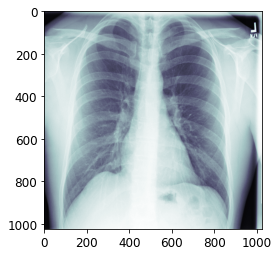

In [173]:
show_patient_data(train_file_names[0])


<br> </br>
## EDA on the Train data !
<br> </br>


### Step 1: Meta Data EDA

#### Step 1.1: General exploration

In [ ]:
train_metadata_df.shape

In [174]:
train_metadata_df.head(3)

,UID,PatientID,Age,Sex,Modality,BodyPart,ViewPosition,Columns,Rows,PatientOrientation,PhotometricInterpretation,PixelSpacing,SamplesPerPixel,Label,Multiple
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,17d405a3-a0d2-4901-b33a-63906aa48d9f,38,M,CR,CHEST,PA,1024.0,1024.0,,MONOCHROME2,"[0.168, 0.168]",1.0,Healthy,0.0
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,8ab1ffda-8b65-4914-95d6-2e549e328666,10,F,CR,CHEST,AP,1024.0,1024.0,,MONOCHROME2,"[0.139, 0.139]",1.0,Healthy,0.0
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,bfef51d3-6541-4792-bac1-d21d41ee60fd,50,F,CR,CHEST,AP,1024.0,1024.0,,MONOCHROME2,"[0.168, 0.168]",1.0,Healthy,0.0


In [175]:
train_metadata_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12089 entries, 0 to 12088
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   UID                        12089 non-null  object 
 1   PatientID                  12089 non-null  object 
 2   Age                        12089 non-null  object 
 3   Sex                        12089 non-null  object 
 4   Modality                   12089 non-null  object 
 5   BodyPart                   12089 non-null  object 
 6   ViewPosition               12089 non-null  object 
 7   Columns                    12089 non-null  float64
 8   Rows                       12089 non-null  float64
 9   PatientOrientation         12089 non-null  object 
 10  PhotometricInterpretation  12089 non-null  object 
 11  PixelSpacing               12089 non-null  object 
 12  SamplesPerPixel            12089 non-null  float64
 13  Label                      12089 non-null  obj

In [176]:
#### We can see that age here is an object and not an int (or float). we'll convert it to int

In [177]:
train_metadata_df['Age'] = train_metadata_df['Age'].astype(str).astype(int)

In [178]:
train_metadata_df.describe(include='all')

,UID,PatientID,Age,Sex,Modality,BodyPart,ViewPosition,Columns,Rows,PatientOrientation,PhotometricInterpretation,PixelSpacing,SamplesPerPixel,Label,Multiple
count,12089,12089,12089.000000,12089,12089,12089,12089,12089.0,12089.0,12089,12089,12089,12089.0,12089,12089.0
unique,12089,12089,NaN,2,1,1,2,NaN,NaN,1,1,11,NaN,3,NaN
top,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,17d405a3-a0d2-4901-b33a-63906aa48d9f,NaN,M,CR,CHEST,PA,NaN,NaN,,MONOCHROME2,"[0.14300000000000002, 0.14300000000000002]",NaN,Healthy,NaN
freq,1,1,NaN,6650,12089,12089,7290,NaN,NaN,12089,12089,4433,NaN,9378,NaN
mean,NaN,NaN,46.987178,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,1.0,NaN,0.0
std,NaN,NaN,17.091074,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,0.0,NaN,0.0
min,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,1.0,NaN,0.0
25%,NaN,NaN,35.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,1.0,NaN,0.0
50%,NaN,NaN,49.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,1.0,NaN,0.0
75%,NaN,NaN,59.000000,NaN,NaN,NaN,NaN,1024.0,1024.0,NaN,NaN,NaN,1.0,NaN,0.0


#### After seeing the stats above, some information can be dropped.
* 'Modality' is always CR (Computed Radiography)
* 'BodyPart' is always CHEST
* 'PatientOrientation' is always empty
* 'PhotometricInterpretation' is always MONOCHROME2
* 'SamplesPerPixel' is always 1
* 'Columns' and 'Rows' are always 1024
* 'Age' contains values that are illegal <-----------

In [219]:
list_of_columns_to_drop = ['Modality','BodyPart','PatientOrientation','PhotometricInterpretation','SamplesPerPixel', 'Columns', 'Rows']
train_metadata_df.drop(columns=list_of_columns_to_drop, inplace=True, errors='ignore')
train_metadata_df.drop(train_metadata_df[train_metadata_df.Age > 120].index, inplace=True)
print(f'dropped {len(list_of_columns_to_drop)} columns')
print(f'dropped {len(train_metadata_df[train_metadata_df.Age > 120].index)} rows')

dropped 7 columns
dropped 0 rows


In [218]:
train_metadata_df.shape

(12087, 8)

In [180]:
train_metadata_df.head(3)

,UID,PatientID,Age,Sex,ViewPosition,PixelSpacing,Label,Multiple
0,1.2.276.0.7230010.3.1.4.8323329.1000.151787516...,17d405a3-a0d2-4901-b33a-63906aa48d9f,38,M,PA,"[0.168, 0.168]",Healthy,0.0
1,1.2.276.0.7230010.3.1.4.8323329.10000.15178752...,8ab1ffda-8b65-4914-95d6-2e549e328666,10,F,AP,"[0.139, 0.139]",Healthy,0.0
2,1.2.276.0.7230010.3.1.4.8323329.10001.15178752...,bfef51d3-6541-4792-bac1-d21d41ee60fd,50,F,AP,"[0.168, 0.168]",Healthy,0.0


#### Check for unique values and their counts in the metadata

In [181]:
for column in list(train_metadata_df.columns):
    if 'ID' not in column and 'EncodedPixels' not in column:
        counts = train_metadata_df[column].value_counts()
        print(f'\nNumber of unique values in column [{column}]: {len(counts)}, Value counts:\n{counts}\n--------------')


Number of unique values in column [Age]: 93, Value counts:
58     368
57     315
51     303
55     295
56     291
      ... 
413      1
94       1
90       1
1        1
148      1
Name: Age, Length: 93, dtype: int64

Number of unique values in column [Sex]: 2, Value counts:
M    6650
F    5439
Name: Sex, dtype: int64

Number of unique values in column [ViewPosition]: 2, Value counts:
PA    7290
AP    4799
Name: ViewPosition, dtype: int64

Number of unique values in column [PixelSpacing]: 11, Value counts:
[0.14300000000000002, 0.14300000000000002]    4433
[0.168, 0.168]                                3681
[0.139, 0.139]                                2259
[0.171, 0.171]                                 891
[0.19431099999999998, 0.19431099999999998]     791
[0.19431400000000001, 0.19431400000000001]      16
[0.19430799999999998, 0.19430799999999998]      12
[0.115, 0.115]                                   2
[0.19378399999999998, 0.19378399999999998]       2
[0.19433599999999998, 0.19433

#### Gender analysis

In [182]:
men = train_metadata_df[train_metadata_df["Sex"] == "M"].shape[0]
women = train_metadata_df[train_metadata_df["Sex"] == "F"].shape[0]

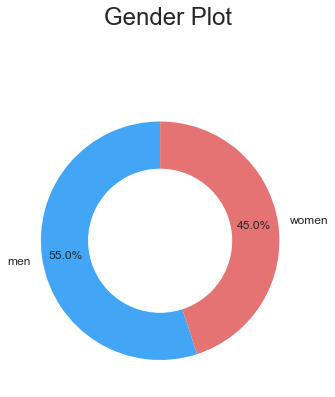

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle("Gender Plot", fontsize=18)
circle0 = plt.Circle( (0,0), 0.6, color = 'white')
ax.pie([men, women], labels=["men", "women"], colors=["#42A5F5", "#E57373"], autopct='%1.1f%%', pctdistance=0.8, startangle=90)
ax.add_patch(circle0)
plt.tight_layout()
plt.show()

#### Illness Analysis

In [205]:
healthy = train_metadata_df[train_metadata_df["Label"] == "Healthy"].shape[0]
ill = train_metadata_df[train_metadata_df["Label"] == "Pneumothorax"].shape[0]

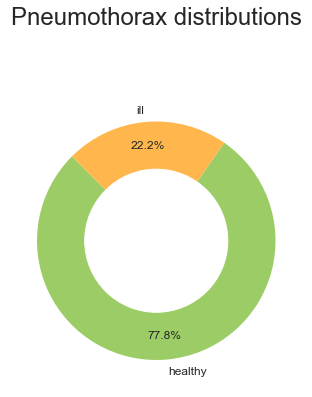

In [206]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig.suptitle("Pneumothorax VS Health", fontsize=18)
circle1 = plt.Circle( (0,0), 0.6, color = 'white')

ax.pie([healthy, ill], labels=["Healthy", "Pneumathorax"], colors=["#9CCC65", "#FFB74D"], autopct='%1.1f%%')
ax.add_patch(circle1)

plt.tight_layout()
plt.show()

#### Gender & Illness Analysis

In [207]:
men_h = train_metadata_df[(train_metadata_df["Sex"] == "M") & (train_metadata_df["Label"] == "Healthy")].shape[0]
men_ill = men - men_h
women_h = train_metadata_df[(train_metadata_df["Sex"] == "F") & (train_metadata_df["Label"] == "Healthy")].shape[0]
women_ill = women - women_h

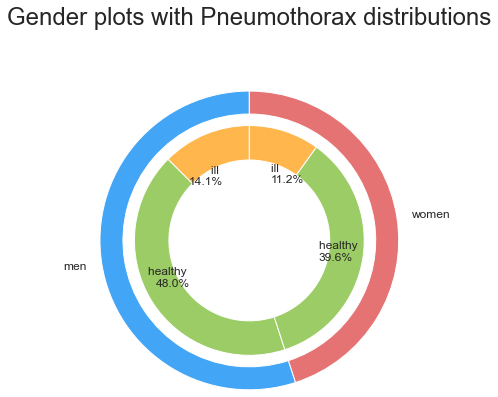

In [208]:
perc = ["ill \n" + str(round(men_ill/107.12, 1)) + "%", 
        "healthy \n" + str(round(men_h/107.12, 1)) + "%", 
        "healthy \n" + str(round(women_h/107.12, 1)) + "%",
        "ill \n" + str(round(women_ill/107.12, 1)) + "%"]

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

fig.suptitle("Gender plots with Pneumothorax distributions", fontsize=18)

mypie, _ = ax.pie([men, women], radius=1.3, labels=["men", "women"], colors=["#42A5F5", "#E57373"], startangle=90)
plt.setp( mypie, width=0.2, edgecolor='white')

mypie2, _ = ax.pie([ men_ill, men_h, women_h, women_ill], radius = 1.3 - 0.3, labels=perc, labeldistance=0.61,
                      colors = ["#FFB74D", "#9CCC65", "#9CCC65", "#FFB74D"], startangle=90)
plt.setp( mypie2, width=0.3, edgecolor='white')

plt.tight_layout()
plt.show()

#### Age Analysis

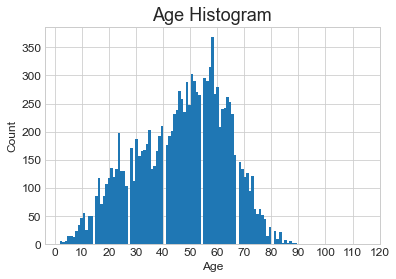

In [222]:
plt.figure()
train_metadata_df["Age"].plot.hist(bins = 100)
plt.title("Age Histogram", fontsize=18)
plt.xlabel("Age")
plt.xticks([i*10 for i in range(11)])
plt.ylabel("Count")
plt.show()

In [ ]:
train_metadata_df['Age'] = train_metadata_df['Age'].astype('int') 
fig, axes = plt.subplots(nrows=1, ncols=1,figsize=(8,4))
sns.boxplot(train_metadata_df['Age'])
axes.title.set_text(f'Age')
plt.show()

#### Age & Illness Analysis

In [ ]:
bins = [i for i in range(100)]

all_men = np.histogram(train_metadata_df[train_metadata_df["Sex"] == "M"]["Age"].values, bins=bins)[0]
all_women = np.histogram(train_metadata_df[train_metadata_df["Sex"] == "F"]["Age"].values, bins=bins)[0]

ill_men = np.histogram(train_metadata_df[(train_metadata_df["Sex"] == "M") & (train_metadata_df["Label"] != 'Healthy')]["Age"].values, bins=bins)[0]
ill_women = np.histogram(train_metadata_df[(train_metadata_df["Sex"] == "F") & (train_metadata_df["Label"] != 'Healthy')]["Age"].values, bins=bins)[0]

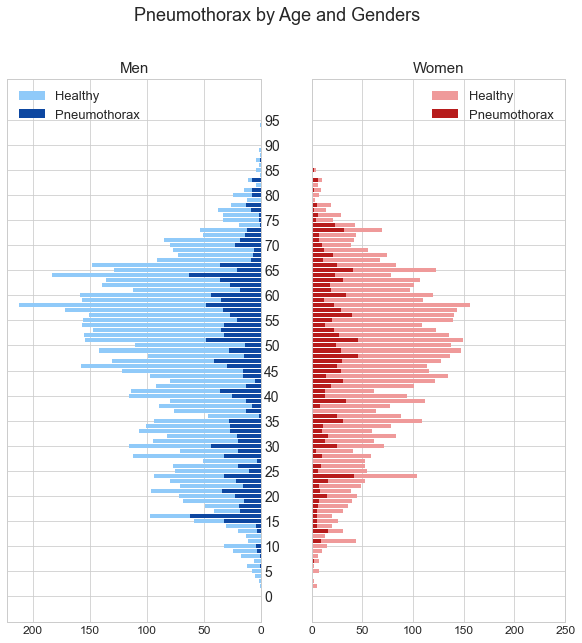

In [231]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 10))
fig.suptitle("Pneumothorax by Age and Genders", fontsize=18)

# Men plot
# axes[0].margins(x=0.1, y=0.01)
m1 = axes[0].barh(bins[:-1], all_men, color='#90CAF9')
m2 = axes[0].barh(bins[:-1], ill_men, color='#0D47A1')
axes[0].set_title('Men', fontsize=15)
axes[0].invert_xaxis()
axes[0].set(yticks=[i*5 for i in range(20)])
axes[0].tick_params(axis="y", labelsize=14)
axes[0].yaxis.tick_right()
# axes[0].xaxis.tick_top()
axes[0].legend((m1[0], m2[0]), ('Healthy', 'Pneumothorax'), loc=2, prop={'size': 13})

# Women plot
# axes[1].margins(y=0.01)
w1 = axes[1].barh(bins[:-1], all_women, color='#EF9A9A')
w2 = axes[1].barh(bins[:-1], ill_women, color='#B71C1C')
axes[1].set_title('Women', fontsize=15)
# axes[1].xaxis.tick_top()
axes[1].legend((w1[0], w2[0]), ('Healthy', 'Pneumothorax'), prop={'size': 13})

# adjust
locs = axes[0].get_xticks()
axes[1].set_xticks(locs)

plt.show()

#### View Positions

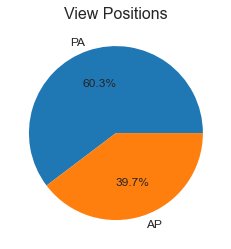

In [237]:
plt.figure()
plt.pie(train_metadata_df["ViewPosition"].value_counts(), labels = ["PA", "AP"], autopct='%1.1f%%') 
plt.title("View Positions", fontsize=16)
plt.show()

/Users/royrubin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 87.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/royrubin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 82.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/royrubin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 65.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/royrubin/.pyenv/versions/3.8.5/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 46.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


CPU times: user 59 s, sys: 742 ms, total: 59.7 s
Wall time: 1min 3s


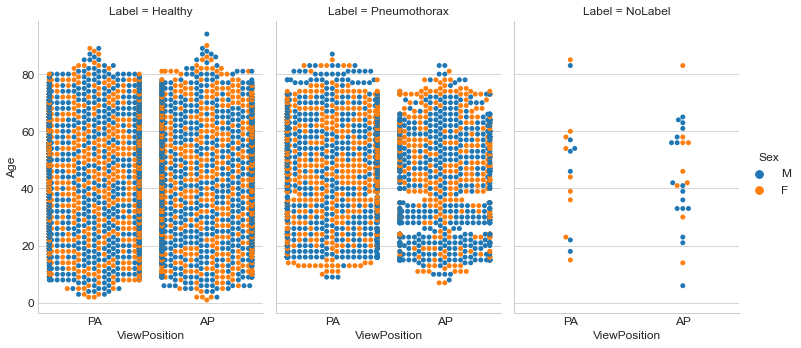

In [249]:
%%time
sns.catplot(x="ViewPosition", y="Age", hue="Sex",
            col="Label", aspect=.7,
            kind="swarm", data=train_metadata_df)

<AxesSubplot:xlabel='ViewPosition', ylabel='count'>

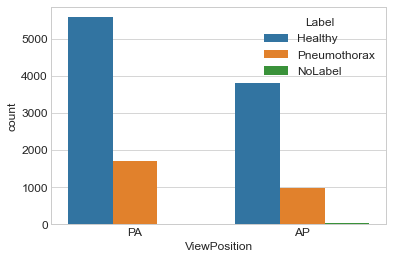

In [250]:
sns.countplot(x="ViewPosition", hue='Label', data=train_metadata_df)

In [ ]:
# # Make data: I have 3 groups and 7 subgroups
# group_names=['groupA', 'groupB', 'groupC']
# group_size=[12,11,30]
# subgroup_names=['A.1', 'A.2', 'A.3', 'B.1', 'B.2', 'C.1', 'C.2', 'C.3', 'C.4', 'C.5']
# subgroup_size=[4,3,5,6,5,10,5,5,4,6]
 
# # Create colors
# a, b, c=[plt.cm.Blues, plt.cm.Reds, plt.cm.Greens]
 
# # First Ring (outside)
# fig, ax = plt.subplots()
# ax.axis('equal')
# mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[a(0.6), b(0.6), c(0.6)] )
# plt.setp( mypie, width=0.3, edgecolor='white')
 
# # Second Ring (Inside)
# mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.7, colors=[a(0.5), a(0.4), a(0.3), b(0.5), b(0.4), c(0.6), c(0.5), c(0.4), c(0.3), c(0.2)])
# plt.setp( mypie2, width=0.4, edgecolor='white')
# plt.margins(0,0)
 
# # show it
# plt.show()

# Others to visualize in metadata eda

## Masks EDA

In [267]:
train_rle_encodings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12954 entries, 0 to 12953
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ImageId         12954 non-null  object
 1    EncodedPixels  12954 non-null  object
dtypes: object(2)
memory usage: 202.5+ KB


In [268]:
train_rle_encodings_df.describe(include='all')

,ImageId,EncodedPixels
count,12954,12954
unique,12047,3577
top,1.2.276.0.7230010.3.1.4.8323329.1851.151787516...,-1
freq,10,9378


#### note from the above that some images have more than one mask !

## Images EDA

In [ ]:
#### Improve the copied function below !

In [251]:
# Copied from Kaggle "mask_functions.py"
def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

In [252]:
def get_bounding_box(img):
    # return max and min of a mask to draw bounding box
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    
    return rmin, cmin, rmax, cmax #ymin,xmin,ymax,cmax

In [300]:
def plot_imgs(uids_list, images_df, rle_encodings_df):
    for uid in uids_list:
        # prepare data for plots
        try:
            image = images_df[images_df.UID == uid].Image.item() # item is added because the result is a series object with 1 element
            rle_encoding = rle_encodings_df[rle_encodings_df.ImageId == uid].EncodedPixels.item()   # same as above
            mask = rle2mask(rle=rle_encoding, width=image.shape[0], height=image.shape[1])
            rmin, cmin, rmax, cmax = get_bounding_box(mask)
            image_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        except Exception as e:
            print(f'could not process image with uid {uid}.\nreason: {e}')
            continue
        
        # Create the figure
        fig, axes = plt.subplots(1,4, figsize=(20,15))
        
        # Create the plot for the original image
        axes[0].imshow(image, cmap='bone')
        axes[0].set_title('Original Image')
        
        # Create the plot for the Pneumathorax mask
        axes[1].imshow(mask, cmap='gray')
        axes[1].set_title('Mask Only')
        
        # Create the plot for the original image with the mask on top of it
        axes[2].imshow(image, cmap='bone')
        axes[2].imshow(mask, alpha=0.3,cmap='Reds')
        axes[2].set_title('Image + mask')
        
        # Create the plot for original image +mask+ mask bounding box
        cv2.rectangle(image_rgb, (cmin,rmin),(cmax,rmax), (255,255,0), 5)
        axes[3].imshow(image_rgb)
        axes[3].imshow(mask,alpha=0.3,cmap='Reds')
        axes[3].set_title('Image + Mask + Bounding Box')
        
        # Finally, show image
        plt.show()

uid 1.2.276.0.7230010.3.1.4.8323329.10005.1517875220.958951


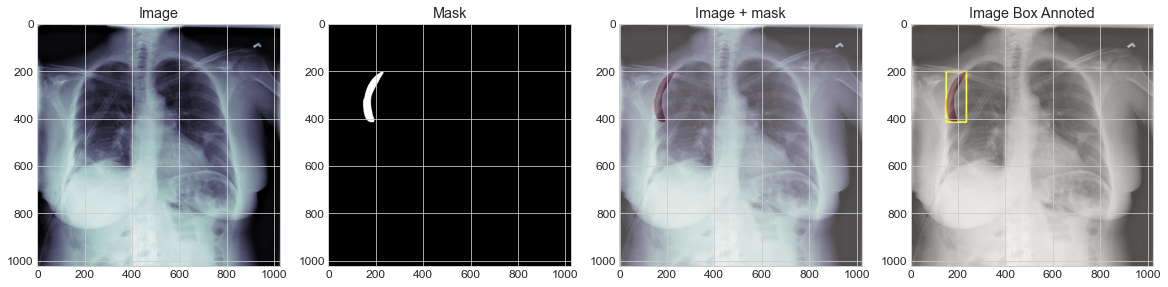

uid 1.2.276.0.7230010.3.1.4.8323329.10011.1517875220.977487
could not process image with uid 1.2.276.0.7230010.3.1.4.8323329.10011.1517875220.977487.
reason: can only convert an array of size 1 to a Python scalar
uid 1.2.276.0.7230010.3.1.4.8323329.10012.1517875220.965942
could not process image with uid 1.2.276.0.7230010.3.1.4.8323329.10012.1517875220.965942.
reason: can only convert an array of size 1 to a Python scalar
uid 1.2.276.0.7230010.3.1.4.8323329.10016.1517875220.992175


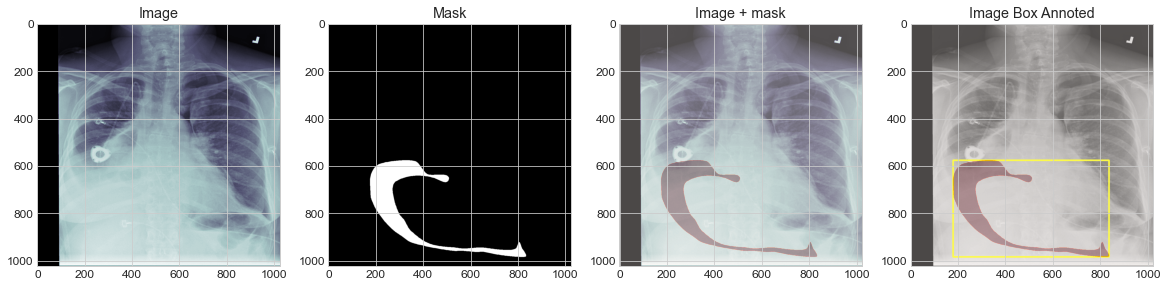

uid 1.2.276.0.7230010.3.1.4.8323329.10025.1517875221.19235


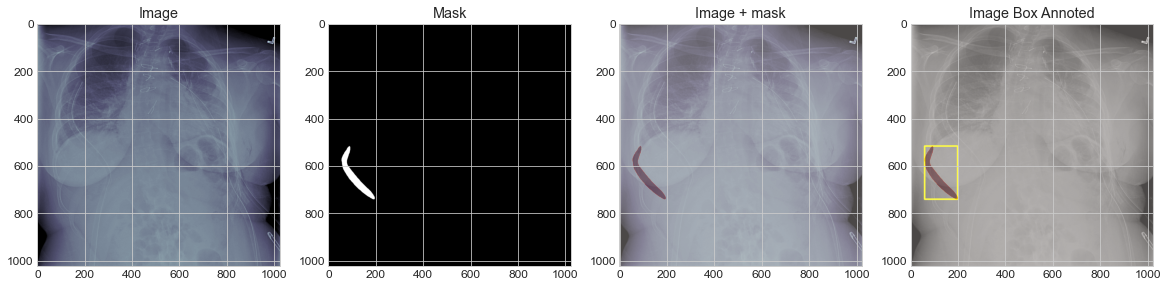

In [301]:
number_of_images_to_plot = 5

tmp = train_metadata_df[train_metadata_df['Label'] == 'Pneumothorax'].reset_index(drop=True)
tmp = tmp.head(number_of_images_to_plot)['UID'].to_list()

plot_imgs(
    uids_list=tmp, 
    images_df=train_images_df, 
    rle_encodings_df=train_rle_encodings_df,
)

<a class="anchor" id="section4"></a>
## 4. Exploring the train metadata 

It seems that some images are missing based on the csv file. Anyway, now we have a dataframe which ease to visualize some aspects of the train metadata. First, let's see the gender and diagnosis distributions.

<a class="anchor" id="section4a"></a>

There are a bit more of men, so in proportion with that, there are a bit more men with Pneumothorax than women. We also know the age of patients, so let's see the age distribution. To create a histogram, we have to know the maximum ages, for example by sorting.

To find out more about the occurence of Pneumothorax at different ages and genders, we can create a plot like the following:

<a class="anchor" id="section4c"></a>

It is striking that many 16-year-old boys suffer from Pneumothorax, even more than the 64 years old men. The result seems unexpected, but if we read more about the disease, it turns out that the [young, tall and thin men](https://edmonton.ctvnews.ca/tall-thin-young-man-you-could-suffer-from-a-collapsed-lung-1.1234203) are more vulnerable. Young women in their twenties don't seem to be an exception. However this information is based only on a small amount of data.

Next let's check the other extracted attributes: Modality, BodyPart, ViewPosition.

As we expected, all the BodyPart fields are chests, the modality is CR, which means Computed Radiography (I think). 

<a class="anchor" id="section4d"></a>
### 4.4 The importance of view positions on an x-ray image 

The view position can be AP or PA. These refer to the way of x-ray in the body, [based on this source](https://www.quora.com/What-is-the-difference-between-an-AP-and-a-PA-view-of-an-X-ray)
* PA: passes from posterior of the body to anterior --> getting better anterior shadings
* AP: passes from anterior of the body to posterior --> getting better posterior shaginds

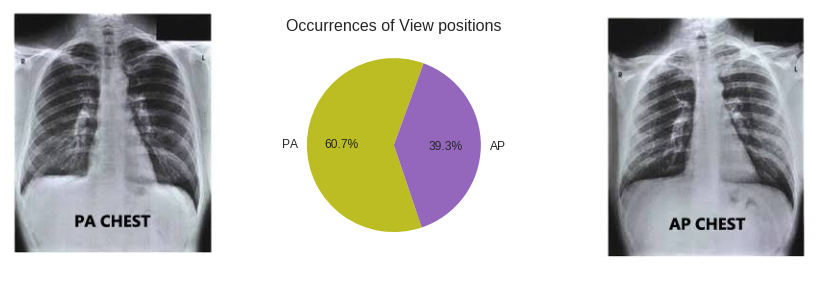

They say usually AP view is used for x-rays, but in the case of the chest x-rays are rather taken from the PA view. If the health level of the patient does not allow to do PA, AP can also help. It would be interesting to check the Pneumothorax severity level in relation to view position too. But first, we have to decode the run-length-encoding (RLE) present int the train csv file. 

<a class="anchor" id="section5"></a>
## 5. The run-length-encoding 

So as we could see, the train csv contains the image id and the rle-encodings of the place of Pneumothorax. But what does this mean? Run-length-encoding (RLE) is a simple lossless compression method, it replaces data sequences with identical values (run) with the respective value stored once and the length of the run. It can be useful when the data contains relatively long sequences. Here is a very simple example. 

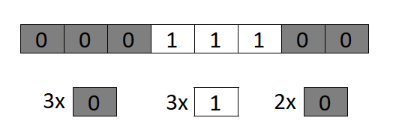

We have to work with **relative** RLE, which means, that the pixel locations are measured from the previous run. For example, '1 3 10 5' implies pixels 1,2,3 are to be included in the mask, as well as 14,15,16,17,18, according to [Robin Schwob](https://www.kaggle.com/schwobr) in this [discussion](https://www.kaggle.com/c/siim-acr-pneumothorax-segmentation/discussion/98397#latest-567740).

<a class="anchor" id="section5a"></a>
### 5.1 Mask functions
Fortunately there are decoding and encoding functions inculded to the sample data: mask_functions.py. As I would like to analyze the train data rle labels, I will use only the rle2mask function. Let's check how it is working.

In [10]:
#mask functions from sample dataset
import numpy as np

def mask2rle(img, width, height):
    rle = []
    lastColor = 0;
    currentPixel = 0;
    runStart = -1;
    runLength = 0;

    for x in range(width):
        for y in range(height):
            currentColor = img[x][y]
            if currentColor != lastColor:
                if currentColor == 255:
                    runStart = currentPixel;
                    runLength = 1;
                else:
                    rle.append(str(runStart));
                    rle.append(str(runLength));
                    runStart = -1;
                    runLength = 0;
                    currentPixel = 0;
            elif runStart > -1:
                runLength += 1
            lastColor = currentColor;
            currentPixel+=1;

    return " ".join(rle)

def rle2mask(rle, width, height):
    mask= np.zeros(width* height)
    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]
    lengths = array[1::2]

    current_position = 0
    for index, start in enumerate(starts):
        current_position += start
        mask[current_position:current_position+lengths[index]] = 255
        current_position += lengths[index]

    return mask.reshape(width, height)

Here are two examples of the encoded pixels. The rle2mask function returns a filter which has the same size as the original image. Some rotation and mirroring were needed, to place the mask correctly.

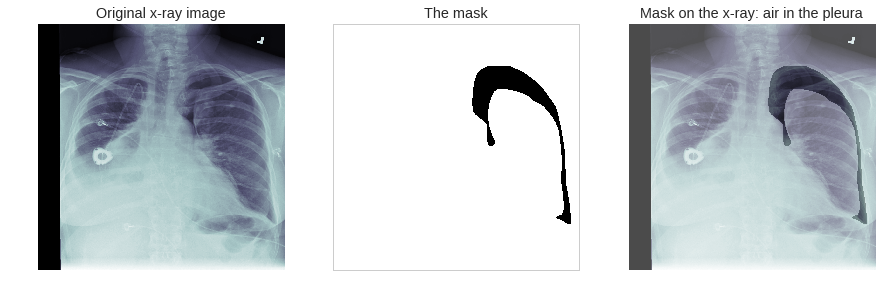

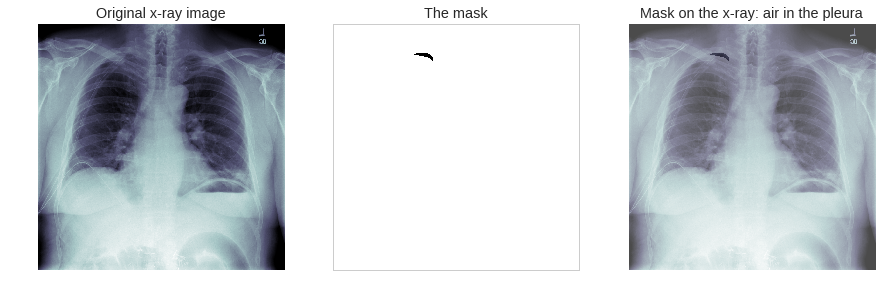

In [11]:
df_pneumo = df_patients[df_patients["EncodedPixels"] != ' -1']

#print(df_pneumo.values[3][2], df_pneumo.values[3][3])

mask = rle2mask(df_pneumo.values[3][1], 1024, 1024)
mask = np.rot90(mask, 3) #rotating three times 90 to the right place
mask = np.flip(mask, axis=1)
img = pydicom.read_file(df_pneumo.values[3][-1]).pixel_array

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray: air in the pleura")

plt.axis("off")

plt.grid(False)

mask = rle2mask(df_pneumo.values[6][1], 1024, 1024)
mask = np.rot90(mask, 3) #rotating three times 90 to the right place
mask = np.flip(mask, axis=1)
img = pydicom.read_file(df_pneumo.values[6][-1]).pixel_array

fig = plt.figure(figsize=(15, 10))
a = fig.add_subplot(1, 3, 1)
plt.imshow(img, cmap='bone') #original x-ray
a.set_title("Original x-ray image")
plt.grid(False)
plt.axis("off")

a = fig.add_subplot(1, 3, 2)
imgplot = plt.imshow(mask, cmap='binary')

a.set_title("The mask")
plt.grid(False)
plt.xticks([])
plt.yticks([])

a = fig.add_subplot(1, 3, 3)
plt.imshow(img, cmap='bone')
plt.imshow(mask, cmap='binary', alpha=0.3)
a.set_title("Mask on the x-ray: air in the pleura")

plt.axis("off")

plt.grid(False)

Now that we can decode the rle, we can analyze some aspects of the masks separately and together with the metadata. Let's start with the area of the air in the chest, which could measure the severity of the disease.

<a class="anchor" id="section6"></a>
## 6. Analyzing the masks

As the masks are created from pixels, we can eaisly count them to calculate the area. As we can see the majority of ill patients suffer from a smaller Pneumothorax, and some patients have a severely collapsed lung. Note: we didn't take in consideration the overlapping masks, just the masked pixels, and at some images the scale may differ too.

In [12]:
area = []
pos = []
pa_area = []
ap_area = []

c = 0

for p in df_pneumo.values:
    try:
        mask = rle2mask(p[1], 1024, 1024)
        pixels = np.count_nonzero(mask)
        area.append(pixels)
        pos.append(p[6])
        if p[6] == "AP":
            ap_area.append(pixels)
        else:
            pa_area.append(pixels)
    except:
        c = c + 1

print("missing labels", c)
print("all area", np.sort(np.array(area)))
#print("ap area", np.sort(np.array(ap_area)))
print("pa area", np.sort(np.array(pa_area)))

missing labels 37
all area [    55     80    201 ... 134354 145885 161421]
pa area [    80    210    212 ...  87976 102743 104516]


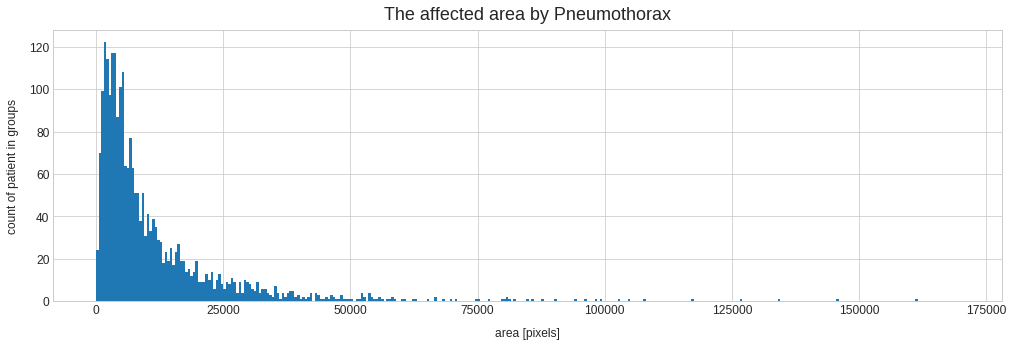

In [13]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(17, 5))
plt.hist(area, bins=[i*500 for i in range(340)])
plt.title("The affected area by Pneumothorax", fontsize=18, pad=10)
plt.xlabel("area [pixels]", labelpad=10)
#plt.xticks([i*10 for i in range(1000)])
plt.ylabel("count of patient in groups", labelpad=10)
plt.show()

<a class="anchor" id="section6a"></a>
### 6.1 The affected area and the view position

As mentioned before, let's see if the "AP" positioned x-ray images has a more serious Pneumothorax? On the plots below can be seen that this supposition tend to be true. The x-ray images with the biggest masks are made in AP position, howewer, this view position occurs fewer times than PA.

Text(0.5, 1.0, 'Occurrences of View positions')

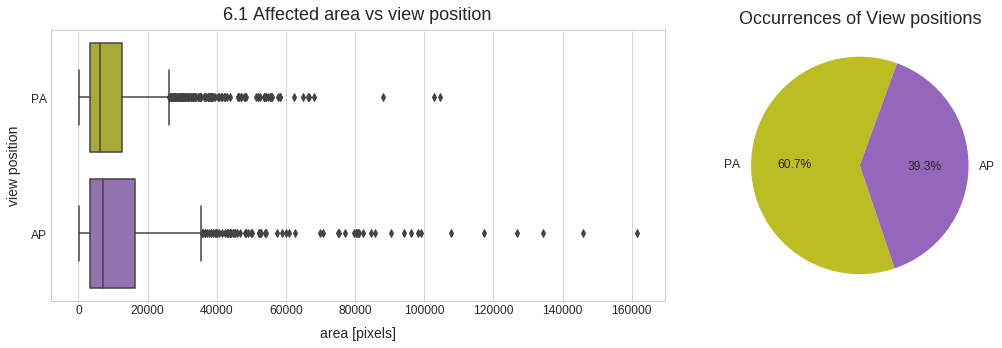

In [14]:
fig = plt.figure(figsize=(17, 5))
basic_palette = sns.color_palette()

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=2)

sns.boxplot(x=area, y=pos, palette={"AP": basic_palette[4], "PA": basic_palette[-2]})#, height=[0.6, 0.4])
ax1.set_xlabel("area [pixels]", fontsize=14, labelpad=10)
ax1.set_ylabel("view position", fontsize=14, labelpad=10)
ax1.set_title("6.1 Affected area vs view position", fontsize=18, pad=10)

ax2 = plt.subplot2grid((1, 3), (0, 2))

ax2.pie([pa, ap], labels = ["PA", "AP"], colors=[basic_palette[-2], basic_palette[4]], autopct='%1.1f%%', startangle=70)
ax2.set_title("Occurrences of View positions", fontsize=18)


<a class="anchor" id="section6b"></a>
### 6.2 The location of Pneumothorax

To get a general insight into the location of Pneumothorax, we can create some "lung heatmaps" for  AP and PA views. Of course, every patient is different, thus the size of the lungs and their place on the x-ray image can be different. However, a heatmap may give an overview.

In [15]:
c = 0
ap_sum = np.array([[0 for i in range(1024)] for j in range(1024)])
pa_sum = np.array([[0 for i in range(1024)] for j in range(1024)])

ap = 0
pa = 0

for p in df_pneumo.values:
    try :
        mask = rle2mask(p[1], 1024, 1024)
        mask = np.rot90(mask, 3) #rotating three times 90 to the right place
        mask = np.flip(mask, axis=1)
        if p[6] == 'AP':
            ap_sum = ap_sum + mask
            ap = ap + 1
        else:
            pa_sum = pa_sum + mask
            pa = pa + 1
    except:
        c = c + 1

([], <a list of 0 Text yticklabel objects>)

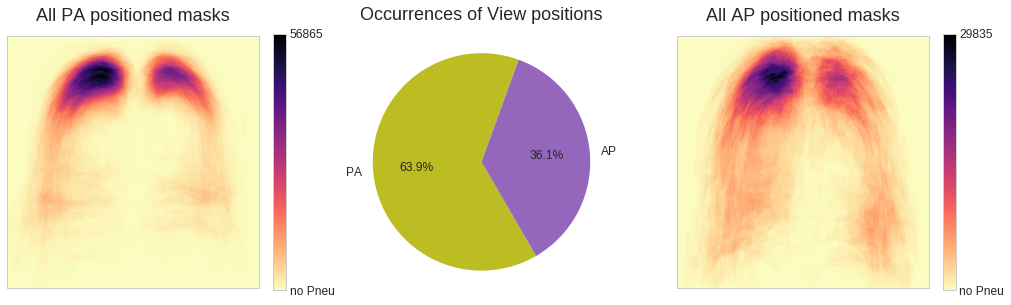

In [16]:
fig = plt.figure(figsize=(17, 5))
basic_palette = sns.color_palette()

ax1 = plt.subplot2grid((1, 3), (0, 0))
ax1.imshow(pa_sum, cmap='magma_r')
ax1.set_title("All PA positioned masks", fontsize=18, pad=15)

#colorbar
maxval = np.max(pa_sum)
cmap = plt.get_cmap('magma_r', maxval)

norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

ticks=[1/(maxval+1)/2, 0.5, 1-1/(maxval+1)/2]

cb_1 = plt.colorbar(sm,ticks=[0, 1], fraction=0.046, ax=ax1)#ticks and boundaries
cb_1.ax.set_yticklabels(["no Pneu", str(int(maxval))]) #label of colormap
cb_1.ax.yaxis.set_label_position('left')

plt.grid(False)
plt.xticks([])
plt.yticks([])

ax2 = plt.subplot2grid((1, 3), (0, 1))
ax2.pie([pa, ap], labels = ["PA", "AP"], colors=[basic_palette[-2], basic_palette[4]], autopct='%1.1f%%', startangle=70)
ax2.set_title("Occurrences of View positions", fontsize=18)

ax3 = plt.subplot2grid((1, 3), (0, 2))
ax3.imshow(ap_sum, cmap='magma_r')
ax3.set_title("All AP positioned masks", fontsize=18, pad=15)

maxval = np.max(ap_sum)
cmap2 = plt.get_cmap('magma_r', maxval)

norm = mpl.colors.Normalize()
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cb_2 = plt.colorbar(sm,ticks=[0, 1], fraction=0.046, ax=ax3)#ticks and boundaries
cb_2.ax.set_yticklabels(["no Pneu", str(int(maxval))]) #label of colormap
cb_2.ax.yaxis.set_label_position('left')

plt.grid(False)
plt.xticks([])
plt.yticks([])

It seems that in both cases the top left corner of the lung is the most common location. In the PA cases, the x-ray images create a cleaner view, the lungs are outlined, while the general lungs of AP cases are noisier and have orange tone. From the colorbar can be read the maximum number of overlapped pixels.

<a class="anchor" id="section7"></a>
## 7. Conclusion

So these were some brief explorations to get a bit more insight into the dataset and its metadata. We have seen the gender and age distributions of healthy and ill people, we discovered more about the x-ray image view positions and about the affected areas. Hopefully, it was useful to understand a bit the nature of the disease and of the affected people.

## Benchmark \ Baseline U-net

In [ ]:
# from: https://github.com/qubvel/segmentation_models.pytorch


model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)
